In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [3]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Some Classification

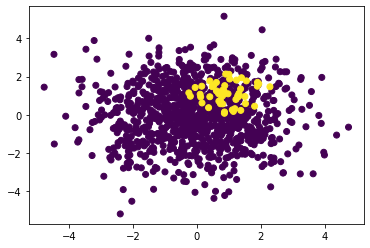

In [4]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

In [5]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
epochs = 10000
learning_rate = 0.01

## TERM/Entropic Risk

In [8]:
class EntropicRisk(nn.Module):
    def __init__(self, t=10, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.t = t
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        # t = 0 should return ERM
        if self.t == 0:
            return torch.mean(loss)
        
        return (1 / self.t) * torch.log(torch.mean(torch.exp(self.t * loss)))

In [9]:
# class EntropicRisk(nn.Module):
#     def __init__(self, t=10, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='none'):
#         super().__init__()
#         self.t = t
#         self.criterion = criterion
#         self.reduction = reduction
    
#     def forward(self, output, labels):
#         loss = self.criterion(output, labels)
#         s# t = 0 should return ERM
#         if self.t == 0:
#             if self.reduction == 'mean':
#                 return torch.mean(loss)
#             elif self.reduction == 'sum':
#                 return torch.sum(loss)
#             return loss
            
#         tilt = torch.exp(self.t * loss)
        
#         if self.reduction == 'mean':
#             return (1 / self.t) * torch.log(torch.mean(tilt))
#         elif self.reduction == 'sum':
#             return (1 / self.t) * torch.log(torch.sum(tilt))
#         return (1 / self.t) * torch.log(tilt)

1.9545141458511353
0.5319837927818298
0.527167022228241
0.5245843529701233
0.5231561064720154
0.5216724872589111
0.5203251242637634
0.5179837942123413
0.5150042176246643
0.5136303305625916
Final loss:  0.5126691460609436


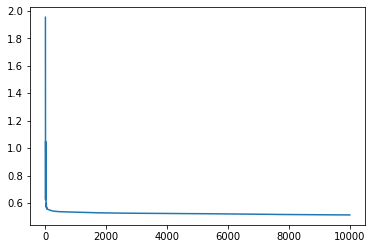

In [11]:
criterion = EntropicRisk()

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

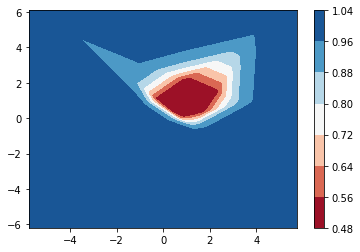

In [12]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## ERM

1.1903595924377441
0.12303086370229721
0.11859708279371262
0.11717519164085388
0.11669063568115234
0.11646942794322968
0.11637378484010696
0.11631780117750168
0.11625199764966965
0.11609449237585068
Final loss:  0.11589740216732025


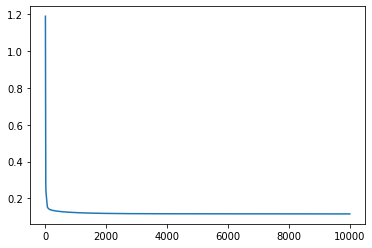

In [13]:
criterion = nn.CrossEntropyLoss()
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

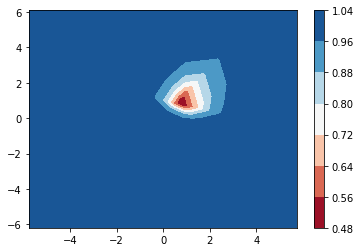

In [14]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Linear Regression

In [15]:
# Taken from TERM Github: https://github.com/litian96/TERM/blob/master/toy_example/linear-regression.ipynb

def abline(a, b, label_, c=None):
    
    """Plot a line from slope and intercept"""
    axes = plt.gca()
#     x_vals = np.array(axes.get_xlim())
    x_vals = np.arange(-3, 3, 0.1)
    y_vals = a * x_vals + b
    plt.plot(x_vals, y_vals, label=label_, color=c, zorder=1)

In [16]:
num_sample = 290
num_outlier = 10
total_samples = num_sample + num_outlier

theta = [-1, 0.2]
#X = np.random.random_sample(num_sample) * 0.5 
X = np.random.normal(0, 0.5, num_sample)
y = theta[0]*X + theta[1] 

y += np.random.normal(0, 0.1, num_sample)

X_out = np.random.normal(-2, 0.5, num_outlier)
y_out = np.random.normal(0, 0.5, num_outlier)

y = np.append(y, y_out)
X = np.append(X, X_out)

print(X.shape, y.shape)

(300,) (300,)


In [17]:
inputs = torch.tensor(X.reshape((-1, 1)), dtype=torch.float32)
labels = torch.tensor(y.reshape((-1, 1)), dtype=torch.float32)

In [18]:
class SimpleLinearRegression(torch.nn.Module):
    def __init__(self):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.linear(x)

Tilt: -1.0 Epoch: 0 Tilt Loss: 0.26070109009742737 MSE Loss: 0.3526216447353363
Tilt: -1.0 Epoch: 100 Tilt Loss: 0.20555518567562103 MSE Loss: 0.26101773977279663
Tilt: -1.0 Epoch: 200 Tilt Loss: 0.16427990794181824 MSE Loss: 0.20024871826171875
Tilt: -1.0 Epoch: 300 Tilt Loss: 0.13377174735069275 MSE Loss: 0.16148273646831512
Tilt: -1.0 Epoch: 400 Tilt Loss: 0.11013033986091614 MSE Loss: 0.13716578483581543
Tilt: -1.0 Epoch: 500 Tilt Loss: 0.0912136510014534 MSE Loss: 0.12311127781867981
Tilt: -1.0 Epoch: 600 Tilt Loss: 0.07616090029478073 MSE Loss: 0.11671147495508194
Tilt: -1.0 Epoch: 700 Tilt Loss: 0.06460375338792801 MSE Loss: 0.11585541069507599
Tilt: -1.0 Epoch: 800 Tilt Loss: 0.05613240972161293 MSE Loss: 0.11863216757774353
Tilt: -1.0 Epoch: 900 Tilt Loss: 0.0501825176179409 MSE Loss: 0.12343676388263702
Tilt: -1.0 Epoch: 1000 Tilt Loss: 0.0461428239941597 MSE Loss: 0.12908311188220978
Tilt: -1.0 Epoch: 1100 Tilt Loss: 0.04346661642193794 MSE Loss: 0.13479846715927124
Tilt: -1

Tilt: -0.9 Epoch: 300 Tilt Loss: 0.049369025975465775 MSE Loss: 0.12917357683181763
Tilt: -0.9 Epoch: 400 Tilt Loss: 0.045480117201805115 MSE Loss: 0.13568511605262756
Tilt: -0.9 Epoch: 500 Tilt Loss: 0.04390326514840126 MSE Loss: 0.14151664078235626
Tilt: -0.9 Epoch: 600 Tilt Loss: 0.04301478713750839 MSE Loss: 0.14622901380062103
Tilt: -0.9 Epoch: 700 Tilt Loss: 0.04246363788843155 MSE Loss: 0.150059312582016
Tilt: -0.9 Epoch: 800 Tilt Loss: 0.042115047574043274 MSE Loss: 0.1531926542520523
Tilt: -0.9 Epoch: 900 Tilt Loss: 0.04189426824450493 MSE Loss: 0.15575464069843292
Tilt: -0.9 Epoch: 1000 Tilt Loss: 0.041754599660634995 MSE Loss: 0.15784145891666412
Tilt: -0.9 Epoch: 1100 Tilt Loss: 0.04166644811630249 MSE Loss: 0.15953344106674194
Tilt: -0.9 Epoch: 1200 Tilt Loss: 0.04161089286208153 MSE Loss: 0.16089920699596405
Tilt: -0.9 Epoch: 1300 Tilt Loss: 0.04157568886876106 MSE Loss: 0.16199767589569092
Tilt: -0.9 Epoch: 1400 Tilt Loss: 0.04155382886528969 MSE Loss: 0.1628783643245697

Tilt: -0.8 Epoch: 600 Tilt Loss: 0.10020731389522552 MSE Loss: 0.1256682276725769
Tilt: -0.8 Epoch: 700 Tilt Loss: 0.08454310894012451 MSE Loss: 0.11756151914596558
Tilt: -0.8 Epoch: 800 Tilt Loss: 0.0726732388138771 MSE Loss: 0.11532104760408401
Tilt: -0.8 Epoch: 900 Tilt Loss: 0.06393030285835266 MSE Loss: 0.11696309596300125
Tilt: -0.8 Epoch: 1000 Tilt Loss: 0.057699285447597504 MSE Loss: 0.12091083824634552
Tilt: -0.8 Epoch: 1100 Tilt Loss: 0.05338684469461441 MSE Loss: 0.12597918510437012
Tilt: -0.8 Epoch: 1200 Tilt Loss: 0.0504719540476799 MSE Loss: 0.13135766983032227
Tilt: -0.8 Epoch: 1300 Tilt Loss: 0.048536233603954315 MSE Loss: 0.1365474909543991
Tilt: -0.8 Epoch: 1400 Tilt Loss: 0.04726730287075043 MSE Loss: 0.14127911627292633
Tilt: -0.8 Epoch: 1500 Tilt Loss: 0.04644373804330826 MSE Loss: 0.14543628692626953
Tilt: -0.8 Epoch: 1600 Tilt Loss: 0.04591246694326401 MSE Loss: 0.14899714291095734
Tilt: -0.8 Epoch: 1700 Tilt Loss: 0.045571647584438324 MSE Loss: 0.151992440223693

Tilt: -0.7000000000000001 Epoch: 1100 Tilt Loss: 0.050579626113176346 MSE Loss: 0.14437338709831238
Tilt: -0.7000000000000001 Epoch: 1200 Tilt Loss: 0.05009988322854042 MSE Loss: 0.14770378172397614
Tilt: -0.7000000000000001 Epoch: 1300 Tilt Loss: 0.049788787961006165 MSE Loss: 0.15051540732383728
Tilt: -0.7000000000000001 Epoch: 1400 Tilt Loss: 0.049587953835725784 MSE Loss: 0.15285955369472504
Tilt: -0.7000000000000001 Epoch: 1500 Tilt Loss: 0.04945836588740349 MSE Loss: 0.15479549765586853
Tilt: -0.7000000000000001 Epoch: 1600 Tilt Loss: 0.04937506839632988 MSE Loss: 0.15638282895088196
Tilt: -0.7000000000000001 Epoch: 1700 Tilt Loss: 0.049321651458740234 MSE Loss: 0.15767721831798553
Tilt: -0.7000000000000001 Epoch: 1800 Tilt Loss: 0.04928736761212349 MSE Loss: 0.15872812271118164
Tilt: -0.7000000000000001 Epoch: 1900 Tilt Loss: 0.04926542192697525 MSE Loss: 0.15957847237586975
Tilt: -0.7000000000000001 Epoch: 2000 Tilt Loss: 0.04925123229622841 MSE Loss: 0.16026480495929718
Tilt: 

Tilt: -0.7000000000000001 Epoch: 9500 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 9600 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 9700 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 9800 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 9900 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 9999 Final loss:  0.049226291477680206 

tensor([[-0.9641]]) tensor([0.1907])
Tilt: -0.6000000000000001 Epoch: 0 Tilt Loss: 0.3427790403366089 MSE Loss: 0.4323239028453827
Tilt: -0.6000000000000001 Epoch: 100 Tilt Loss: 0.2593468129634857 MSE Loss: 0.30910882353782654
Tilt: -0.6000000000000001 Epoch: 200 Tilt Loss: 0.19763202965259552 MSE Loss: 0.22612719237804413
Tilt: -0.6000000000000001 Epoch: 300 Tilt Loss: 0.15563541650772095 MSE Loss: 0.1749994158744812
Til

Tilt: -0.6000000000000001 Epoch: 7800 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 7900 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8000 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8100 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8200 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8300 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8400 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8500 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8600 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8700 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6

Tilt: -0.5000000000000001 Epoch: 6000 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6100 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6200 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6300 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6400 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6500 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6600 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6700 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6800 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6900 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.50000000000

Tilt: -0.40000000000000013 Epoch: 4400 Tilt Loss: 0.06973317265510559 MSE Loss: 0.1471121460199356
Tilt: -0.40000000000000013 Epoch: 4500 Tilt Loss: 0.06973317265510559 MSE Loss: 0.147123321890831
Tilt: -0.40000000000000013 Epoch: 4600 Tilt Loss: 0.06973317265510559 MSE Loss: 0.14713254570960999
Tilt: -0.40000000000000013 Epoch: 4700 Tilt Loss: 0.06973317265510559 MSE Loss: 0.1471400409936905
Tilt: -0.40000000000000013 Epoch: 4800 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14714622497558594
Tilt: -0.40000000000000013 Epoch: 4900 Tilt Loss: 0.06973317265510559 MSE Loss: 0.14715145528316498
Tilt: -0.40000000000000013 Epoch: 5000 Tilt Loss: 0.06973317265510559 MSE Loss: 0.14715538918972015
Tilt: -0.40000000000000013 Epoch: 5100 Tilt Loss: 0.06973317265510559 MSE Loss: 0.1471588909626007
Tilt: -0.40000000000000013 Epoch: 5200 Tilt Loss: 0.06973317265510559 MSE Loss: 0.14716151356697083
Tilt: -0.40000000000000013 Epoch: 5300 Tilt Loss: 0.06973317265510559 MSE Loss: 0.14716413617134094
Tilt:

Tilt: -0.30000000000000016 Epoch: 2700 Tilt Loss: 0.080105260014534 MSE Loss: 0.13531428575515747
Tilt: -0.30000000000000016 Epoch: 2800 Tilt Loss: 0.08010464906692505 MSE Loss: 0.13539236783981323
Tilt: -0.30000000000000016 Epoch: 2900 Tilt Loss: 0.08010464906692505 MSE Loss: 0.1354566365480423
Tilt: -0.30000000000000016 Epoch: 3000 Tilt Loss: 0.08010464906692505 MSE Loss: 0.13550952076911926
Tilt: -0.30000000000000016 Epoch: 3100 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1355530470609665
Tilt: -0.30000000000000016 Epoch: 3200 Tilt Loss: 0.08010383695363998 MSE Loss: 0.1355888992547989
Tilt: -0.30000000000000016 Epoch: 3300 Tilt Loss: 0.08010383695363998 MSE Loss: 0.13561837375164032
Tilt: -0.30000000000000016 Epoch: 3400 Tilt Loss: 0.08010383695363998 MSE Loss: 0.1356426179409027
Tilt: -0.30000000000000016 Epoch: 3500 Tilt Loss: 0.08010383695363998 MSE Loss: 0.1356625109910965
Tilt: -0.30000000000000016 Epoch: 3600 Tilt Loss: 0.08010383695363998 MSE Loss: 0.13567890226840973
Tilt: -

Tilt: -0.20000000000000018 Epoch: 1000 Tilt Loss: 0.09227319061756134 MSE Loss: 0.11877207458019257
Tilt: -0.20000000000000018 Epoch: 1100 Tilt Loss: 0.0920770913362503 MSE Loss: 0.11959972232580185
Tilt: -0.20000000000000018 Epoch: 1200 Tilt Loss: 0.09195171296596527 MSE Loss: 0.12031394988298416
Tilt: -0.20000000000000018 Epoch: 1300 Tilt Loss: 0.09187187999486923 MSE Loss: 0.12091861665248871
Tilt: -0.20000000000000018 Epoch: 1400 Tilt Loss: 0.09182058274745941 MSE Loss: 0.12142374366521835
Tilt: -0.20000000000000018 Epoch: 1500 Tilt Loss: 0.0917884036898613 MSE Loss: 0.12184171378612518
Tilt: -0.20000000000000018 Epoch: 1600 Tilt Loss: 0.09176715463399887 MSE Loss: 0.12218508124351501
Tilt: -0.20000000000000018 Epoch: 1700 Tilt Loss: 0.09175410866737366 MSE Loss: 0.12246567755937576
Tilt: -0.20000000000000018 Epoch: 1800 Tilt Loss: 0.09174591302871704 MSE Loss: 0.12269403040409088
Tilt: -0.20000000000000018 Epoch: 1900 Tilt Loss: 0.09174014627933502 MSE Loss: 0.1228792667388916
Til

Tilt: -0.20000000000000018 Epoch: 9400 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9500 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9600 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9700 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9800 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9900 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 9999 Final loss:  0.09173043072223663 

tensor([[-0.7683]]) tensor([0.1715])
Tilt: -0.1000000000000002 Epoch: 0 Tilt Loss: 1.2904984951019287 MSE Loss: 1.2957857847213745
Tilt: -0.1000000000000002 Epoch: 100 Tilt Loss: 0.27402815222740173 MSE Loss: 0.2834842801094055
Tilt: -0.1000000000000002 Epoch: 200 Tilt Loss: 0.12772783637046814 MSE Loss: 0.1425398290157318
T

Tilt: -0.1000000000000002 Epoch: 7800 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 7900 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8000 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8100 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8200 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8300 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8400 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8500 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8600 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1000000000000002 Epoch: 8700 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622300744056702
Tilt: -0.1

Tilt: -2.220446049250313e-16 Epoch: 8300 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8400 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8500 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8600 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8700 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8800 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 8900 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 9000 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 9100 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 9200 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 9300 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 9400 Ti

Tilt: 0.09999999999999964 Epoch: 8800 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 8900 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9000 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9100 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9200 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9300 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9400 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9500 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9600 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 9700 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoc

Tilt: 0.19999999999999973 Epoch: 7200 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7300 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7400 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7500 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7600 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7700 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7800 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 7900 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 8000 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.19999999999999973 Epoch: 8100 Tilt Loss: 0.13378916680812836 MSE Loss: 0.1183692142367363
Tilt: 0.199999999999

Tilt: 0.2999999999999998 Epoch: 5500 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 5600 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 5700 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 5800 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 5900 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 6000 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 6100 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 6200 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 6300 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.2999999999999998 Epoch: 6400 Tilt Loss: 0.14280618727207184 MSE Loss: 0.12194348871707916
Tilt: 0.299999999999

Tilt: 0.3999999999999997 Epoch: 5700 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 5800 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 5900 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6000 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6100 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6200 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6300 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6400 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6500 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.3999999999999997 Epoch: 6600 Tilt Loss: 0.15151584148406982 MSE Loss: 0.12577374279499054
Tilt: 0.399999999999

Tilt: 0.49999999999999956 Epoch: 4000 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4100 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4200 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4300 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4400 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4500 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4600 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4700 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4800 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.49999999999999956 Epoch: 4900 Tilt Loss: 0.16003090143203735 MSE Loss: 0.1296175867319107
Tilt: 0.499999999999

Tilt: 0.5999999999999996 Epoch: 2300 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2400 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2500 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2600 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2700 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2800 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 2900 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 3000 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 3100 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.5999999999999996 Epoch: 3200 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334177434444427
Tilt: 0.599999999999

Tilt: 0.6999999999999997 Epoch: 600 Tilt Loss: 0.17684565484523773 MSE Loss: 0.1367308646440506
Tilt: 0.6999999999999997 Epoch: 700 Tilt Loss: 0.17684143781661987 MSE Loss: 0.13680975139141083
Tilt: 0.6999999999999997 Epoch: 800 Tilt Loss: 0.17684069275856018 MSE Loss: 0.13684488832950592
Tilt: 0.6999999999999997 Epoch: 900 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13686026632785797
Tilt: 0.6999999999999997 Epoch: 1000 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13686694204807281
Tilt: 0.6999999999999997 Epoch: 1100 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13686981797218323
Tilt: 0.6999999999999997 Epoch: 1200 Tilt Loss: 0.17684052884578705 MSE Loss: 0.1368710696697235
Tilt: 0.6999999999999997 Epoch: 1300 Tilt Loss: 0.17684052884578705 MSE Loss: 0.1368715912103653
Tilt: 0.6999999999999997 Epoch: 1400 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 1500 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Ep

Tilt: 0.7999999999999996 Epoch: 900 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401635706424713
Tilt: 0.7999999999999996 Epoch: 1000 Tilt Loss: 0.18528884649276733 MSE Loss: 0.1401665210723877
Tilt: 0.7999999999999996 Epoch: 1100 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401677429676056
Tilt: 0.7999999999999996 Epoch: 1200 Tilt Loss: 0.18528857827186584 MSE Loss: 0.14016824960708618
Tilt: 0.7999999999999996 Epoch: 1300 Tilt Loss: 0.1852887123823166 MSE Loss: 0.14016848802566528
Tilt: 0.7999999999999996 Epoch: 1400 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 1500 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 1600 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 1700 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 1800 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 1900 

Tilt: 0.8999999999999995 Epoch: 1300 Tilt Loss: 0.1938588172197342 MSE Loss: 0.14321167767047882
Tilt: 0.8999999999999995 Epoch: 1400 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 1500 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 1600 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 1700 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 1800 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 1900 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 2000 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 2100 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 2200 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999

Tilt: 0 Epoch: 1900 Tilt Loss: 0.11423512548208237 MSE Loss: 0.11423512548208237
Tilt: 0 Epoch: 2000 Tilt Loss: 0.11423506587743759 MSE Loss: 0.11423506587743759
Tilt: 0 Epoch: 2100 Tilt Loss: 0.11423501372337341 MSE Loss: 0.11423501372337341
Tilt: 0 Epoch: 2200 Tilt Loss: 0.11423499882221222 MSE Loss: 0.11423499882221222
Tilt: 0 Epoch: 2300 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 2400 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 2500 Tilt Loss: 0.11423497647047043 MSE Loss: 0.11423497647047043
Tilt: 0 Epoch: 2600 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 2700 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 2800 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 2900 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 3000 Tilt Loss: 0.11423497647047043 MSE Loss: 0.11423497647047043
Tilt: 0 Epoch: 3100 Tilt Los

Tilt: 1 Epoch: 4000 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4100 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4200 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4300 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4400 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4500 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4600 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4700 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4800 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 4900 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 5000 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 5100 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599499106407166
Tilt: 1 Epoch: 5200 Tilt Los

Tilt: 2 Epoch: 4500 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 4600 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 4700 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 4800 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 4900 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5000 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5100 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5200 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5300 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5400 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5500 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5600 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 5700 Tilt Loss: 0.3137553

Tilt: 3 Epoch: 4900 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5000 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5100 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5200 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5300 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5400 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5500 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5600 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5700 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5800 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 5900 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 6000 Tilt Loss: 0.4913141429424286 MSE Loss: 0.16679809987545013
Tilt: 3 Epoch: 6100 Tilt Loss: 0.4913141

Tilt: 4 Epoch: 5200 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 5300 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 5400 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 5500 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 5600 Tilt Loss: 0.6989396810531616 MSE Loss: 0.17391030490398407
Tilt: 4 Epoch: 5700 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 5800 Tilt Loss: 0.6989396810531616 MSE Loss: 0.17391030490398407
Tilt: 4 Epoch: 5900 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 6000 Tilt Loss: 0.6989396810531616 MSE Loss: 0.17391030490398407
Tilt: 4 Epoch: 6100 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 6200 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 6300 Tilt Loss: 0.6989396214485168 MSE Loss: 0.17391029000282288
Tilt: 4 Epoch: 6400 Tilt Loss: 0.6989396

Tilt: 5 Epoch: 5600 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 5700 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 5800 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 5900 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6000 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6100 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6200 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6300 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6400 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6500 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6600 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6700 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 6800 Tilt Loss: 0.8752509

Tilt: 6 Epoch: 6100 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6200 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6300 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6400 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6500 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6600 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6700 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6800 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 6900 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 7000 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 7100 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 7200 Tilt Loss: 1.0084686279296875 MSE Loss: 0.1915861964225769
Tilt: 6 Epoch: 7300 Tilt Loss: 1.0084686279296875 MS

Tilt: 7 Epoch: 6600 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 6700 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 6800 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 6900 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7000 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7100 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7200 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7300 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7400 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7500 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7600 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7700 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 7800 Tilt Loss: 1.108527660369873

Tilt: 8 Epoch: 7100 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7200 Tilt Loss: 1.1854727268218994 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7300 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7400 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7500 Tilt Loss: 1.1854727268218994 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7600 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7700 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7800 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 7900 Tilt Loss: 1.1854727268218994 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 8000 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 8100 Tilt Loss: 1.185472846031189 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 8200 Tilt Loss: 1.1854727268218994 MSE Loss: 0.2026413381099701
Tilt: 8 Epoch: 8300 Tilt Loss: 1.185472846031189 MSE Loss: 0

Tilt: 9 Epoch: 7600 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 7700 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 7800 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 7900 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8000 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8100 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8200 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8300 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8400 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8500 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8600 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8700 Tilt Loss: 1.2462390661239624 MSE Loss: 0.20625770092010498
Tilt: 9 Epoch: 8800 Tilt Loss: 1.2462390

Tilt: 10 Epoch: 8100 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8200 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8300 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8400 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8500 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8600 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8700 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8800 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 8900 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 9000 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 9100 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 9200 Tilt Loss: 1.2953779697418213 MSE Loss: 0.2090778648853302
Tilt: 10 Epoch: 9300 Tilt Loss: 1.295377

Tilt: 11 Epoch: 8600 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 8700 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 8800 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 8900 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9000 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9100 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9200 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9300 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9400 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9500 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9600 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9700 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437
Tilt: 11 Epoch: 9800 Tilt Loss: 1.33591890335083 MSE Loss: 0.211328387260437

Tilt: 12 Epoch: 9100 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9200 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9300 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9400 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9500 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9600 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9700 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9800 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9900 Tilt Loss: 1.3699347972869873 MSE Loss: 0.21316298842430115
Tilt: 12 Epoch: 9999 Final loss:  1.3699347972869873 

tensor([[-0.1589]]) tensor([0.3403])
Tilt: 13 Epoch: 0 Tilt Loss: 1.690506100654602 MSE Loss: 0.23174333572387695
Tilt: 13 Epoch: 100 Tilt Loss: 1.3988865613937378 MSE Loss: 0.21468663215637207
Tilt: 13 Epoch: 200 Ti

Tilt: 13 Epoch: 9600 Tilt Loss: 1.3988865613937378 MSE Loss: 0.2146872729063034
Tilt: 13 Epoch: 9700 Tilt Loss: 1.3988865613937378 MSE Loss: 0.2146872729063034
Tilt: 13 Epoch: 9800 Tilt Loss: 1.3988865613937378 MSE Loss: 0.2146872729063034
Tilt: 13 Epoch: 9900 Tilt Loss: 1.3988865613937378 MSE Loss: 0.2146873027086258
Tilt: 13 Epoch: 9999 Final loss:  1.3988865613937378 

tensor([[-0.1575]]) tensor([0.3439])
Tilt: 14 Epoch: 0 Tilt Loss: 5.2822089195251465 MSE Loss: 0.8797054290771484
Tilt: 14 Epoch: 100 Tilt Loss: 1.5815532207489014 MSE Loss: 0.3268522620201111
Tilt: 14 Epoch: 200 Tilt Loss: 1.5542616844177246 MSE Loss: 0.25252634286880493
Tilt: 14 Epoch: 300 Tilt Loss: 1.5277155637741089 MSE Loss: 0.20070210099220276
Tilt: 14 Epoch: 400 Tilt Loss: 1.5018407106399536 MSE Loss: 0.17045387625694275
Tilt: 14 Epoch: 500 Tilt Loss: 1.476603388786316 MSE Loss: 0.16097328066825867
Tilt: 14 Epoch: 600 Tilt Loss: 1.4519965648651123 MSE Loss: 0.17149266600608826
Tilt: 14 Epoch: 700 Tilt Loss: 1.

Tilt: 15 Epoch: 100 Tilt Loss: 1.6345208883285522 MSE Loss: 0.43439850211143494
Tilt: 15 Epoch: 200 Tilt Loss: 1.6063798666000366 MSE Loss: 0.3344824016094208
Tilt: 15 Epoch: 300 Tilt Loss: 1.5791468620300293 MSE Loss: 0.25826767086982727
Tilt: 15 Epoch: 400 Tilt Loss: 1.5526413917541504 MSE Loss: 0.2045193761587143
Tilt: 15 Epoch: 500 Tilt Loss: 1.526796817779541 MSE Loss: 0.17233549058437347
Tilt: 15 Epoch: 600 Tilt Loss: 1.5015770196914673 MSE Loss: 0.16091880202293396
Tilt: 15 Epoch: 700 Tilt Loss: 1.476965069770813 MSE Loss: 0.1695200353860855
Tilt: 15 Epoch: 800 Tilt Loss: 1.4532965421676636 MSE Loss: 0.1971670389175415
Tilt: 15 Epoch: 900 Tilt Loss: 1.4455463886260986 MSE Loss: 0.21704141795635223
Tilt: 15 Epoch: 1000 Tilt Loss: 1.4455465078353882 MSE Loss: 0.21707895398139954
Tilt: 15 Epoch: 1100 Tilt Loss: 1.4455463886260986 MSE Loss: 0.21707895398139954
Tilt: 15 Epoch: 1200 Tilt Loss: 1.4455465078353882 MSE Loss: 0.21707895398139954
Tilt: 15 Epoch: 1300 Tilt Loss: 1.445546507

Tilt: 16 Epoch: 500 Tilt Loss: 1.4878530502319336 MSE Loss: 0.17754991352558136
Tilt: 16 Epoch: 600 Tilt Loss: 1.4662275314331055 MSE Loss: 0.21046066284179688
Tilt: 16 Epoch: 700 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803754568099976
Tilt: 16 Epoch: 800 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 900 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1000 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1100 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1200 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1300 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1400 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1500 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1600 Tilt Loss: 1.464627742767334 MSE Loss: 0.21803705394268036
Tilt: 16 Epoch: 1700 Tilt Loss: 1.464627742

Tilt: 17 Epoch: 1100 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1200 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1300 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1400 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1500 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1600 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1700 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1800 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 1900 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2000 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2100 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2200 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2300 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2400 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2500 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2600 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2700 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2800 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 2900 Tilt Loss: nan MSE Loss: nan
Tilt: 17 Epoch: 3000 Tilt Loss: nan MSE Loss: nan


Tilt: 18 Epoch: 7900 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8000 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8100 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8200 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8300 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8400 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8500 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8600 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8700 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8800 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 8900 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9000 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9100 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9200 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9300 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9400 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9500 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9600 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9700 Tilt Loss: nan MSE Loss: nan
Tilt: 18 Epoch: 9800 Tilt Loss: nan MSE Loss: nan


Tilt: 20 Epoch: 4700 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 4800 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 4900 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5000 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5100 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5200 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5300 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5400 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5500 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5600 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5700 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5800 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 5900 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6000 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6100 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6200 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6300 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6400 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6500 Tilt Loss: nan MSE Loss: nan
Tilt: 20 Epoch: 6600 Tilt Loss: nan MSE Loss: nan


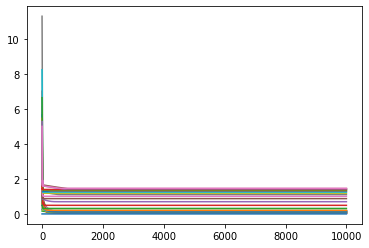

In [21]:
epochs = 10000

tilts = [i for i in np.arange(-1, 1, 0.1)] + [i for i in np.arange(0, 21, 1)]
weights = []
biases = []
final_losses = []

for t in tilts:
    criterion = EntropicRisk(t=t, criterion=nn.MSELoss(reduction='none'))
    mse_criterion = nn.MSELoss()

    model = SimpleLinearRegression()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)

        # negative likelihood (expected risk)
        loss = criterion(output, labels)
        mse_loss = mse_criterion(output, labels)
        losses.append(loss.item())

        if epoch % 100 == 0:
            print('Tilt:', t, 'Epoch:', epoch, 'Tilt Loss:', loss.item(), 'MSE Loss:', mse_loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print('Tilt:', t, 'Epoch:', epoch, 'Final loss: ', losses[-1], '\n')
    
    [w, b] = model.parameters()
    print(w.data, b.data)
    w1, b1 = w.data[0][0], b.data[0]
    
    weights.append(w1)
    biases.append(b1)
    final_losses.append(losses[-1])
    
    plt.plot(losses)

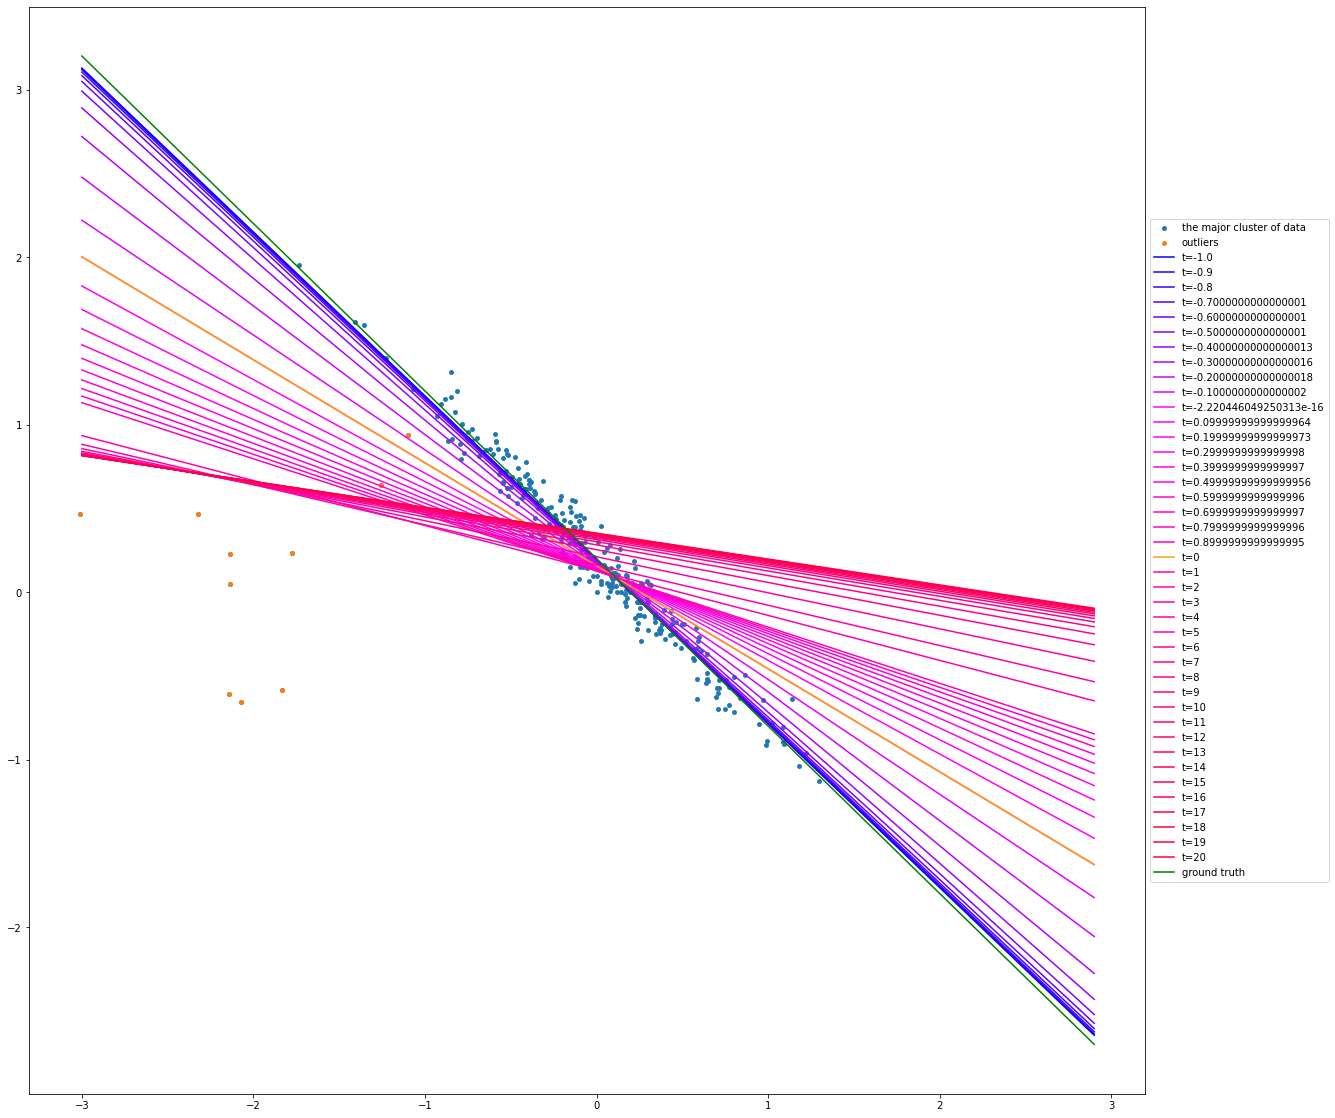

In [22]:
plt.figure(figsize=(20, 20))
plt.scatter(X, y, s=15, label='the major cluster of data')
plt.scatter(X_out, y_out, s=15, label="outliers")

blue = (0, 0, 1)
red = (1, 0, 1)

for i, t in enumerate(tilts):
    color = 'orange'
    if t < 0:
        color = blue
        blue = (blue[0] + 0.1, blue[1], blue[2])
    elif t > 0:
        color = red
        red = (red[0], red[1], red[2] - 0.03)
    abline(weights[i], biases[i], 't=' + str(t), color)
abline(theta[0], theta[1], 'ground truth', 'green')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))